In [72]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from dependency_decoding import chu_liu_edmonds
from pathlib import Path
from collections import defaultdict
import warnings

In [73]:
sent = np.load("en.200.npz")
T_proj = sent['projection_tensor']
source_langs = sent['source_languages']

In [74]:
def count_correct(pred_heads, gold_heads):
    assert len(pred_heads) == len(gold_heads)
    # Do not count the root attachment at index 0 as correct
    return sum(pred == gold for pred, gold in zip(pred_heads, gold_heads)) - 1


In [75]:
T_proj_de = T_proj[:,:,4]

D = pd.DataFrame(T_proj_de)
T_proj.shape

(22, 22, 11)

In [76]:
T_proj_de[2] = np.nanmin(T_proj_de)
T_proj_de[6] = np.nanmin(T_proj_de)
T_proj_de[9] = np.nanmin(T_proj_de)

pred_heads, tree_score = chu_liu_edmonds(T_proj_de)
gold_heads = np.concatenate([[-1], sent["heads"]])
print(pred_heads, gold_heads)
count_correct(pred_heads, gold_heads)

[-1, 0, 0, 14, 9, 0, 0, 4, 7, 0, 0, 9, 20, 0, 20, 0, 20, 0, 0, 20, 4, 0] [-1 20  4  4  1  7  7  1  9  7  7 12  7 18 18 18 18 18 20 20  0  5]


1

In [77]:
#import warnings
#warnings.filterwarnings('ignore', r"")

p = Path(".")
scores = defaultdict(list)
sent_lens = []
tree_scores = defaultdict(list)

def softmax(sentence_matrix, temperature=1.0):
    m_exp = np.exp(sentence_matrix/temperature)
    return (m_exp.T / np.nansum(m_exp, axis=1)).T

def l1_normalize(M):
    return (M.T / np.nansum(M, axis=1)).T

def eliminate_all_nan_vals(M_proj):
    M_proj[np.isnan(M_proj)] = np.nanmin(M_proj)
    
#    with warnings.catch_warnings():
#        warnings.simplefilter("ignore")
#        by_row = np.nanmax(M_proj, axis=1)
#        all_nan_rows = np.isnan(by_row)
#        M_proj[all_nan_rows] = np.nanmin(M_proj)

def eval_projection(M_proj, name, gold_heads):
    eliminate_all_nan_vals(M_proj)
    pred_heads_from_all, tree_score = chu_liu_edmonds(M_proj)
    scores[name].append(count_correct(pred_heads_from_all, gold_heads))
    tree_scores[name].append(tree_score)

def apply_softmax_per_row_per_lang(T_proj):
    for lang in range(T_proj.shape[2]):
        T_proj_lang = T_proj[:,:,lang]
        T_proj[:,:,lang] = softmax(T_proj_lang, temperature=1)
    
token_count = 0


for file in p.glob("*.npz"):
    sent = np.load(str(file))
    T_proj = sent['projection_tensor']
    
    #print(T_proj.shape[2])
    #if T_proj.shape[2] < 15:
    #    print(T_proj.shape[2])
    #    continue
    
    source_langs = sent['source_languages']
    
    # apply_softmax_per_row_per_lang(T_proj)
    
    gold_heads = np.concatenate([[-1], sent["heads"]])
    for lang in range(T_proj.shape[2]):
        lang_name = source_langs[lang]
        
        T_proj_lang = T_proj[:,:,lang]
        T_proj_lang = np.where(np.isnan(T_proj_lang), np.nanmin(T_proj_lang), T_proj_lang)
        pred_heads, tree_score = chu_liu_edmonds(T_proj_lang)
        
        scores[lang_name].append(count_correct(pred_heads, gold_heads))
        tree_scores[lang_name].append(tree_score)
        
        
    # Aggregate measures
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_projection(np.nansum(T_proj, axis=2), "all_sum", gold_heads)
        eval_projection(np.nanmean(T_proj, axis=2), "all_mean", gold_heads)
        eval_projection(np.nanmax(T_proj, axis=2), "all_max", gold_heads)

        eval_projection(softmax(np.nansum(T_proj, axis=2)), "all_sum_softmax", gold_heads)
        eval_projection(softmax(np.nanmean(T_proj, axis=2)), "all_mean_softmax", gold_heads)

        eval_projection(l1_normalize(np.nansum(T_proj, axis=2)), "all_sum_l1", gold_heads)
    
    
    sent_lens.append(len(pred_heads) - 1)
    token_count += len(pred_heads) - 1

aggregated_scores = {k: sum(vals) for k, vals in scores.items()}
aggregated_tree_scores = {k: np.nansum(vals) for k, vals in tree_scores.items()}
print(token_count)
pd.DataFrame({"tree_score": pd.Series(aggregated_tree_scores), 
              "accuracy": pd.Series(aggregated_scores)})

26211


/Users/anders/anaconda/lib/python3.4/site-packages/numpy/lib/nanfunctions.py:227: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)


,accuracy,tree_score
all_max,6490,3.803357e+04
all_mean,7245,1.958231e+04
all_mean_softmax,7220,4.203221e+03
all_sum,7696,1.196722e+05
all_sum_l1,5236,-1.626463e+05
all_sum_softmax,7651,1.184934e+04
bg,4038,-1.199478e+04
cs,2634,-1.212358e+04
da,3599,-inf
de,2687,-3.684915e+03


In [78]:
sum(scores['all_sum'])

7696

In [79]:
np.nansum([np.nan, np.nan])

0.0

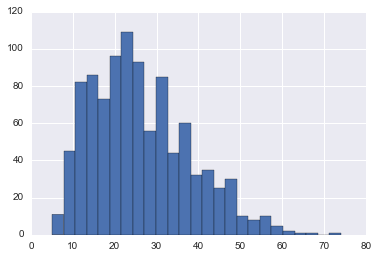

In [80]:
D = pd.DataFrame({"accuracy": np.array(scores["all_sum"])  / np.array(sent_lens), 
                  "tree_score": np.array(tree_scores["all_sum"]),
                  "norm_tree_score": np.array(tree_scores["all_sum"]) / np.array(sent_lens),
                  "sent_lens": np.array(sent_lens)}
                )

#for i in range(11):
#    print(D[D.accuracy > i / 10].sent_lens.mean())

D.sent_lens.hist(bins=25)
#D[D.sent_lens > 35].accuracy.mean()




In [81]:
sent['heads']

array([ 3,  3,  0,  3,  3,  7,  3,  5, 12, 12, 12,  3, 12, 16, 16, 12, 16,
       16, 20, 18, 20, 23, 21, 25, 21, 27, 25,  5])

In [82]:
x = np.zeros(M_norm.shape[1]) * np.nan
M_norm = np.vstack([x, M_norm])
chu_liu_edmonds(M_norm)

NameError: name 'M_norm' is not defined

In [ ]:
num_sources_list = []
means_per_lang = []
for file in p.glob("*.npz"):
    sent = np.load(str(file))
    T_proj = sent['projection_tensor']
    source_langs = sent['source_languages']
    num_sources_list.append(T_proj.shape[2])
    mean_dict = {source_langs[i]: np.nanmean(T_proj[:,:,i]) for i in range(T_proj.shape[2])}
    means_per_lang.append(mean_dict)


In [69]:
D = pd.DataFrame(means_per_lang)
D.describe()

,bg,cs,da,de,fa,fi,he,hi,hr,it,no,pl,pt,sl,sv
count,8.270000e+02,6.920000e+02,6.590000e+02,5.290000e+02,5.540000e+02,5.650000e+02,7.410000e+02,8.230000e+02,4.740000e+02,6.530000e+02,6.060000e+02,8.070000e+02,7.690000e+02,7.140000e+02,6.100000e+02
mean,6.866475e-04,1.514315e-03,7.821129e-04,1.167160e-03,2.518515e-04,1.353746e-03,1.172519e-03,5.994757e-04,2.890350e-03,1.456627e-04,4.413121e-04,1.630313e-03,9.014523e-04,5.926616e-04,2.120540e-03
std,8.053266e-03,1.328844e-02,7.707696e-03,9.563783e-03,8.888136e-03,1.021424e-02,1.756469e-02,1.214415e-02,2.287896e-02,5.412038e-03,4.273810e-03,8.325419e-03,8.635372e-03,6.392921e-03,9.739576e-03
min,-9.310775e-02,-1.356914e-01,-3.934938e-02,-6.069539e-02,-5.820968e-02,-3.450285e-02,-5.827789e-02,-2.666448e-01,-9.620435e-02,-6.286183e-02,-1.909448e-02,-2.074462e-02,-8.900437e-02,-5.635882e-02,-2.200036e-02
25%,-7.985081e-14,-6.971131e-14,-7.040020e-14,-8.180085e-14,-9.367192e-14,-8.622436e-14,-9.053869e-14,-9.280119e-14,-9.994703e-14,-1.032149e-13,-7.287118e-14,-7.933053e-14,-8.504475e-14,-8.853551e-14,-8.647100e-14
50%,-1.083066e-15,6.818115e-15,1.120363e-14,5.552657e-15,-3.457136e-15,9.796877e-16,1.054166e-14,4.991892e-15,4.617906e-15,-3.353868e-15,9.976376e-15,1.065814e-15,9.023666e-16,5.462046e-15,-8.464298e-15
75%,8.807200e-14,9.518177e-14,8.790998e-14,8.120377e-14,8.784283e-14,7.784565e-14,1.402705e-13,1.041069e-13,1.197451e-13,9.065341e-14,8.572357e-14,9.116398e-14,9.311373e-14,8.510738e-14,8.281315e-14
max,8.282813e-02,1.991103e-01,1.220448e-01,8.892991e-02,1.060084e-01,1.267895e-01,4.393373e-01,1.025508e-01,3.304789e-01,5.936294e-02,6.074690e-02,9.936869e-02,1.314451e-01,8.669438e-02,8.578066e-02


,bg,cs,da,de,fa,fi,he,hi,hr,it,no,pl,pt,sl,sv
0,-5.973000e-14,1.889780e-14,-9.374908e-14,-2.536153e-13,1.739671e-14,-2.815759e-13,2.776428e-13,NaN,-3.319142e-13,-1.609769e-13,1.302214e-13,NaN,7.917681e-14,-2.057275e-13,-1.087536e-14
1,1.809346e-13,NaN,-2.199485e-13,NaN,NaN,-5.388046e-13,-4.750089e-13,1.695648e-13,3.664624e-13,NaN,NaN,1.000089e-13,NaN,NaN,-8.796519e-14
2,1.725858e-13,-4.183195e-02,NaN,-6.069539e-02,-8.212875e-14,NaN,-2.717678e-13,NaN,1.694694e-13,-7.007728e-15,NaN,-2.726849e-13,-1.367513e-14,-3.268834e-02,NaN
3,NaN,5.278766e-02,1.009735e-02,NaN,-3.416341e-13,-1.487807e-13,NaN,NaN,-5.635681e-03,NaN,NaN,NaN,-4.945465e-14,-3.067740e-14,1.366473e-13
4,6.250001e-13,3.603340e-14,NaN,-5.294196e-13,-7.501407e-14,NaN,1.351646e-13,NaN,2.603103e-13,6.932973e-14,8.004179e-14,-1.791530e-13,1.999979e-13,-5.700329e-13,NaN
5,1.840023e-13,9.417808e-14,NaN,6.165003e-15,NaN,NaN,1.390180e-13,NaN,-1.648214e-13,2.396287e-14,1.584520e-14,-1.081425e-13,-8.112400e-14,8.687293e-14,NaN
6,1.301374e-13,NaN,NaN,-1.451979e-13,NaN,NaN,-1.135188e-13,2.570942e-14,-1.083454e-13,NaN,-1.335586e-13,-2.711019e-14,-1.634060e-13,-3.149470e-14,NaN
7,1.765209e-13,NaN,NaN,-2.226311e-13,NaN,NaN,-1.250111e-14,2.025272e-13,3.785861e-13,NaN,2.684262e-13,2.580815e-13,-1.459603e-14,1.851191e-13,NaN
8,-2.540503e-13,NaN,NaN,-6.545875e-14,NaN,NaN,-2.105918e-14,2.510547e-13,NaN,-7.575758e-14,-3.666463e-14,4.941080e-13,-3.458530e-13,2.116733e-13,NaN
9,-4.367487e-13,4.063541e-13,3.058958e-13,9.406617e-15,1.306075e-13,3.990553e-13,NaN,2.428005e-13,NaN,3.717799e-14,4.445278e-14,-1.670433e-13,1.034268e-13,2.390449e-14,-2.227571e-13
